# EveryBeam OSKAR-"MWA" integration tests

Test that the signs of everything in the Jones matrix allow for Stokes IQUV recovery and RM recovery. First up, define some skymodels for tests. Test the currrent `MWA_FEE` primary model as a control. We'll compare this to a quasi MWA beam model using the `everybeam` `OSKAR` beam model. We can make a measurement set with the MWA array layout and the tile configuration, and then just use the `OSKAR` dipole model to do the beam forming. This let's us compare results with known tested `hyperbeam` `MWA_FEE`.

Goes without saying, but these tests rely on `everybeam` being installed.

In [1]:
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.everybeam import load_OSKAR_telescope, load_LOFAR_telescope, get_everybeam_norm, run_everybeam, radec_to_xyz
import erfa
import mwa_hyperbeam

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

/home/jack-line/software/WODEN_dev/test_installation/everybeam/eb_testing_code.py:406: SyntaxWarning: invalid escape sequence '\p'
  axs.set_xlabel("$\phi$ (rad m$^{-2}$)")


Set up some observationals parameters. 

In [2]:
ra0 = 0.0
dec0 = -26.7
MWA_LAT=-26.703319405555554

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=116.67081523611111*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")


LST: 0.00455202630786671 deg, RA: 0.0


## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


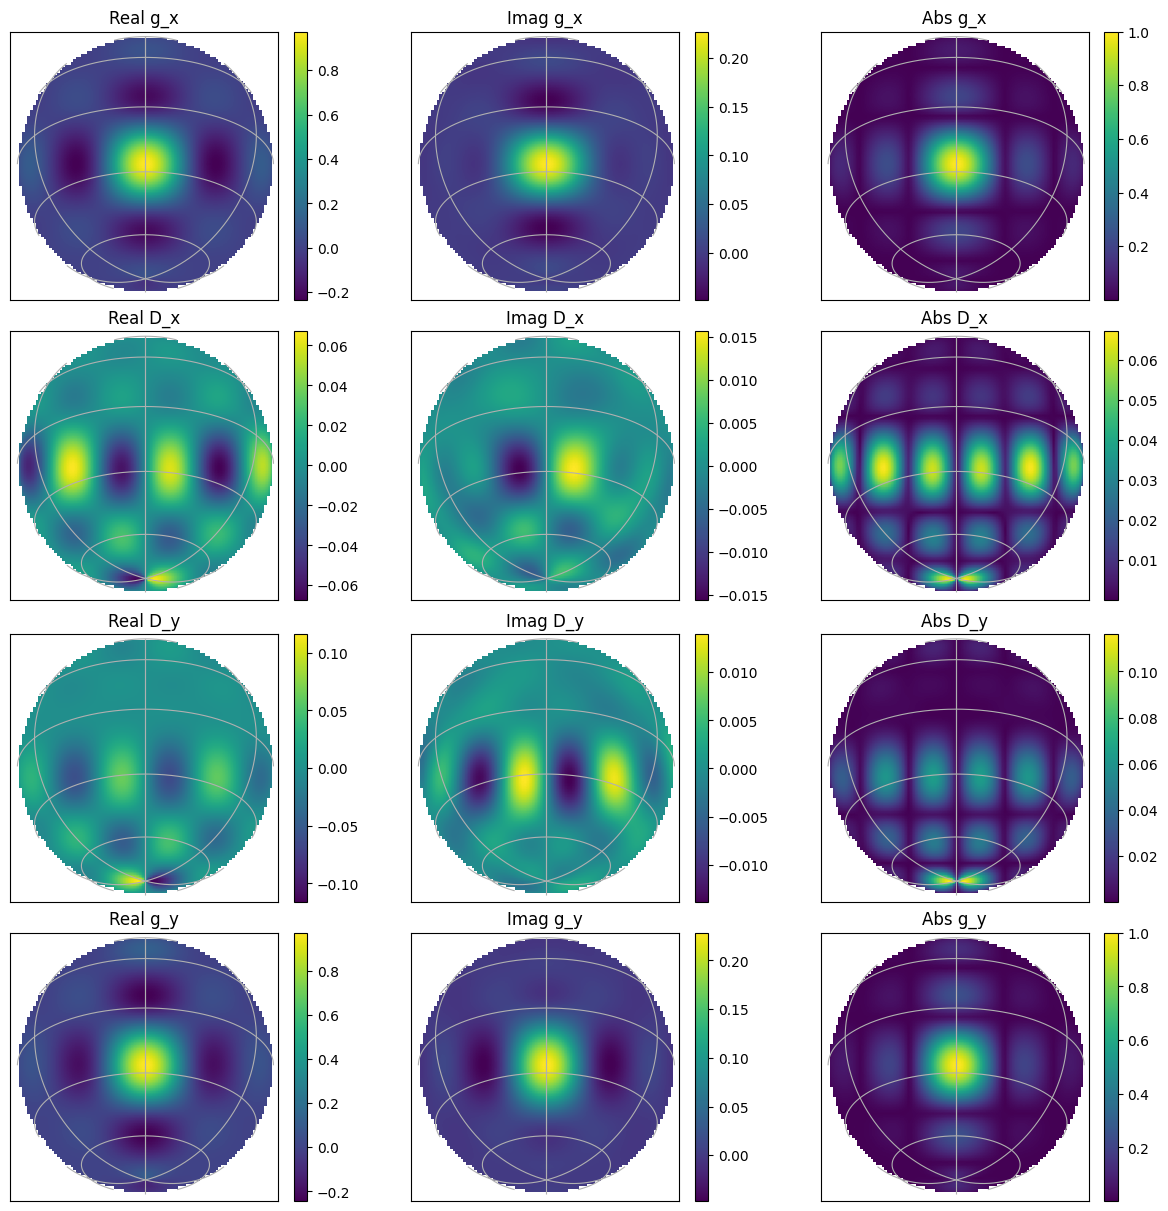

In [3]:
nside=100
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

##Then use erfa to convert these values into azs, els
has = LST_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT))

za_grid = np.pi/2 - els

beam = mwa_hyperbeam.FEEBeam()

freq = 180e+6


jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16, True, np.radians(MWA_LAT), True)


all_gx = jones[:,0]
all_Dx = jones[:,1]
all_Dy = jones[:,2]
all_gy = jones[:,3]

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs)

Next, let's do the equivalent for the `everybeam` `OSKAR` "MWA" beam model and see how it compares

2024-08-26 05:46:46	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:46:46	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:46:46	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:46:46	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:46:46	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:46:46	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:46:46	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 MHz instead


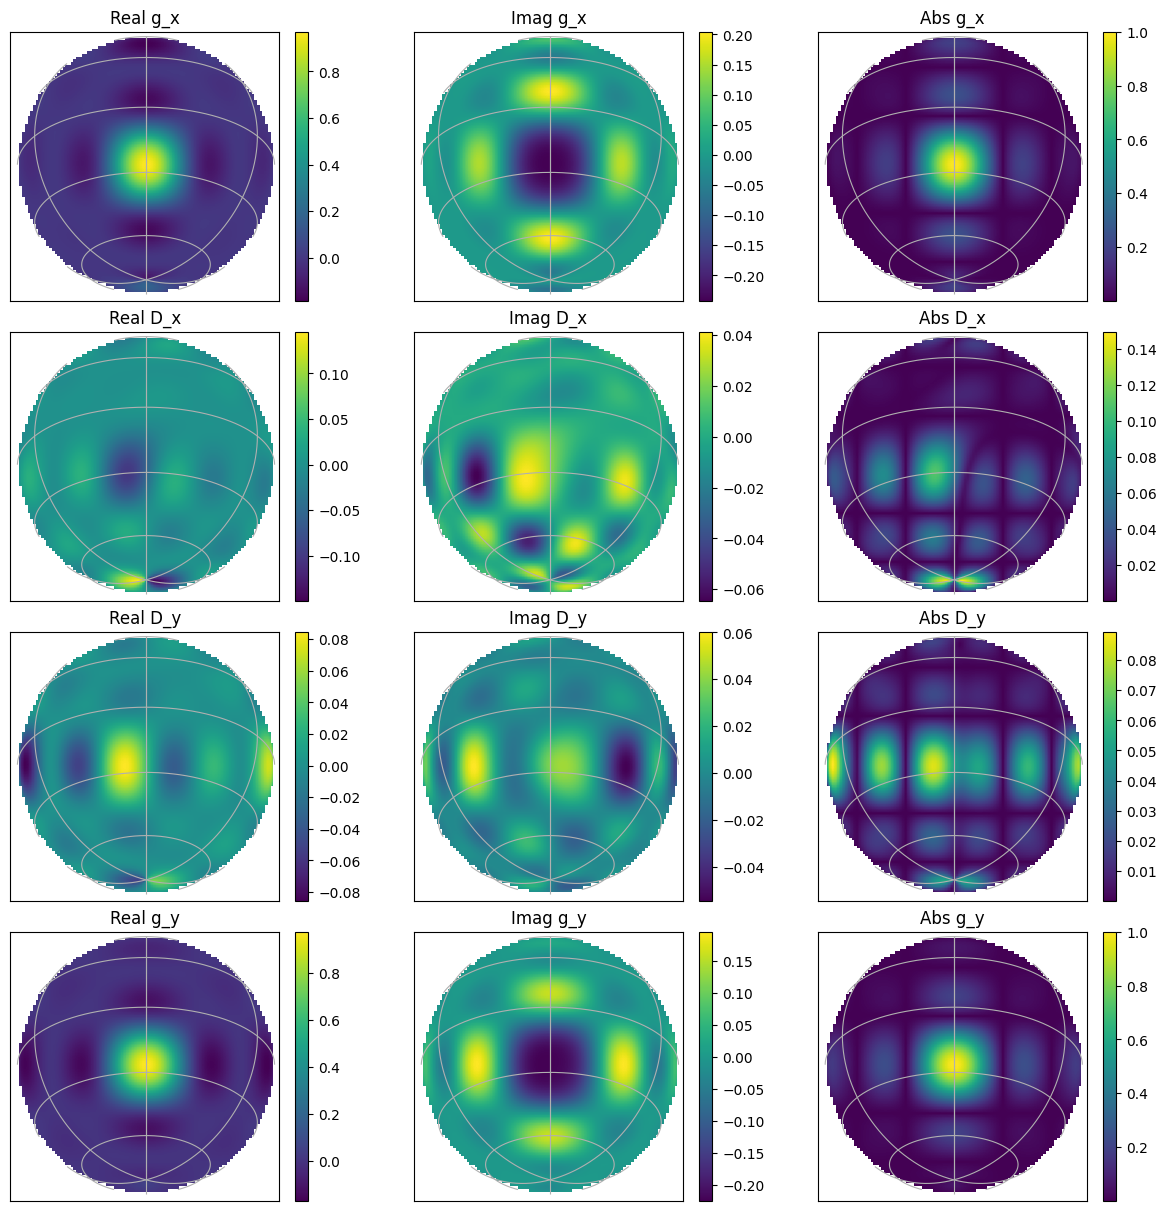

In [4]:
##I made the measurement set using OSKAR with the MWA layout
ms_path="OSKAR-MWA-layout.ms"

# Load the telescope
telescope = load_OSKAR_telescope(ms_path)  
station_id = 0
    
plot_everybeam_on_sky(ra0, dec0, observing_time, 180e6, station_id, telescope)

Soooo there are a couple of differences, but the amplitudes of the X and Y beams are pretty similar which is schweet

## Stokes IQUV recovery

Now test that we can recover Stokes IQUV from a point source.

Make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [5]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [6]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through the MWA FEE beam. We're avoiding using metafits here to be as apples to apples with `EveryBeam` as possible.

In [7]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "MWA_FEE"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]'
    
    call(command, shell=True)

You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 2
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 2
YO YO YO woden_settings->beamtype: 2
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf oth

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [8]:

for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)
    


Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


### Do it with `OSKAR` "MWA" `everybeam`

Right, try and do the same thing with `OSKAR` "MWA" `everybeam`

In [9]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_OSKAR"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f'--beam_ms_path=OSKAR-MWA-layout.ms'
    
    call(command, shell=True)

You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 6
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 181 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for fre

2024-08-26 05:47:00	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:47:00	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:47:00	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:47:00	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:47:00	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:47:00	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:47:00	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 200 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 201 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 202 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 203 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 204 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 205 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 206 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 207 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 208 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 209 MHz, using the nearest 

2024-08-26 05:47:02	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:47:02	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:47:02	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:47:02	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:47:02	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:47:02	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:47:02	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 191 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 192 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 193 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 194 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 195 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 196 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest 

2024-08-26 05:47:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:47:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:47:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:47:04	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:47:04	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:47:04	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:47:04	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 189 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 190 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 191 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 192 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 193 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 194 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 195 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 196 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest 

2024-08-26 05:47:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:47:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:47:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:47:06	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:47:06	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:47:06	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:47:06	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 201 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 202 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 203 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 204 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 205 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 206 MHz, using the nearest 

In [10]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'everybeam_OSKAR', atol=3e-2)
    
    ##Uncomment to print out example values
    
    # uvfits_name = f"stokes{pol}_everybeam_OSKAR"
    # XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0

    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    # print(pol, recover_I[0].real, recover_Q[0].real, recover_U[0].real, recover_V[0].real)

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [11]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN.

In [12]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]'

call(command, shell=True)

You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 2
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 2
YO YO YO woden_settings->beamtype: 2
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf oth

0

Have a look and check our visis make sense

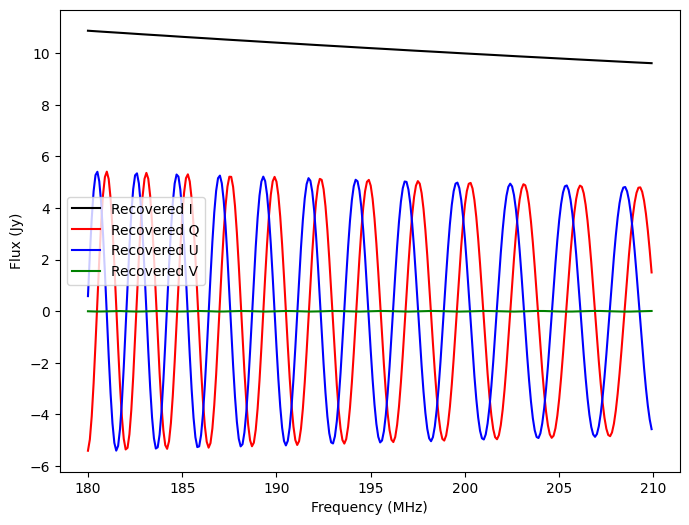

In [13]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Now define a test, using a bunch of Emil's RM synthesis code. 

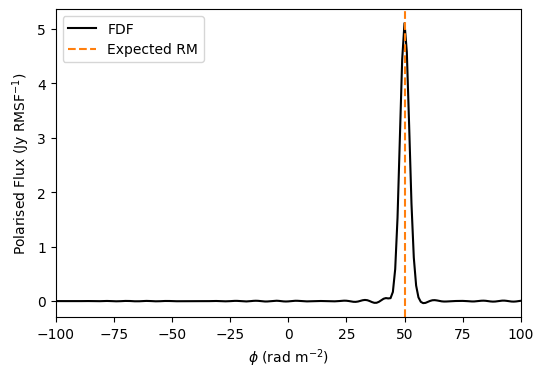

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999532 Expected Pol Fraction 0.5


In [14]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

### Do it with `everybeam`

In [15]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_OSKAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--beam_ms_path=OSKAR-MWA-layout.ms'

call(command, shell=True)

You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 6
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for fre

2024-08-26 05:47:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:47:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:47:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:47:10	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:47:10	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:47:10	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:47:10	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 181 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 181 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest 

0

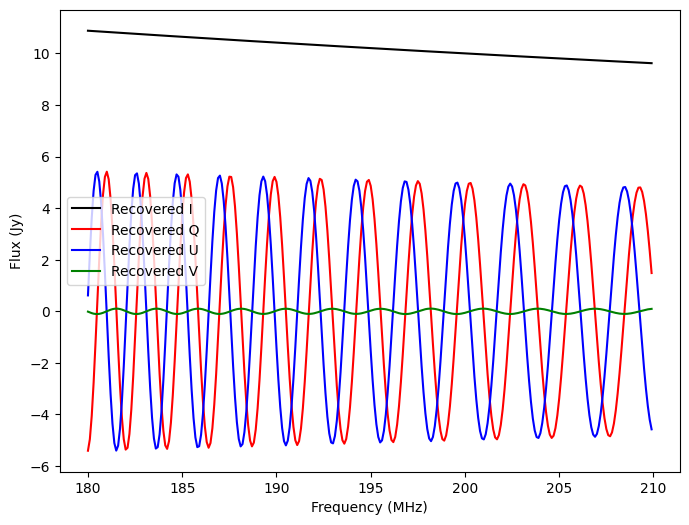

In [16]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_OSKAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

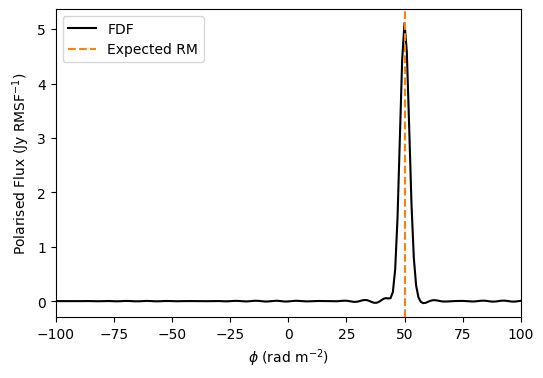

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49994996 Expected Pol Fraction 0.5


In [17]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)